#**Classification: Iris Dataset**

> *by Onkar Mehra*

Performed **exploratory data analysis**

Tried six different classification algorithms:
1. Decision Tree
2. Random Forest Classifier
3. Gaussian Naive Bayes  
4. Logistic Regression
5. K-Nearest Neighbours
6. Linear SVC

*Evaluation metric:* **accuracy** and **cross_val_score** (with **StratifiedKFold**)

Tried **hyperparameter tuning** using **BayesSearchCV** on **K-Nearest Neigbours** and **Linear SVC** to see if our chosen hyperparameter values gave close to optimum results

## *Step 1*: **Importing necessary libraries**

In [ ]:
pip install git+https://github.com/scikit-optimize/scikit-optimize.git

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV

#While execution, hide the warnings.warn raised by the BayesSearchCV optimizer
import warnings
warnings.simplefilter('ignore') 

## *Step 2*: **Loading the dataset**

In [3]:
url = "https://raw.githubusercontent.com/XaviPat01/ML-Models/main/Iris%20Dataset/iris.csv"
dataset = pd.read_csv(url)

dataset.head(5)

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [4]:
dataset.drop("Unnamed: 0",axis=1, inplace = True)
dataset.head(5)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
dataset.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
dataset.groupby('Species').size()

Species
setosa        50
versicolor    50
virginica     50
dtype: int64

In [7]:
dataset_X = dataset[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']]
dataset_Y = dataset.Species

features=['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']
ftrnames = ['Sepal Length','Sepal Width','Petal Length','Petal Width']
cn = ['setosa','versicolor','virginica']

## *Step 3*: **Exploratory Data Analysis**



### ***Histogram***
Allows us to check for symmetry and skewness in data. Gives us an overall idea of maximum and minimum values of features. 

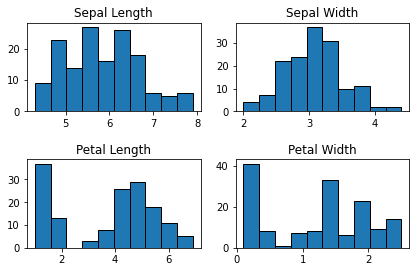

In [8]:
fig,axs = plt.subplots(2,2)
axs[0,0].hist(dataset['Sepal.Length'], edgecolor = 'black', linewidth = 1)
axs[0,0].set_title('Sepal Length')
axs[0,1].hist(dataset['Sepal.Width'], edgecolor = 'black', linewidth = 1)
axs[0,1].set_title('Sepal Width')
axs[1,0].hist(dataset['Petal.Length'], edgecolor = 'black', linewidth = 1)
axs[1,0].set_title('Petal Length')
axs[1,1].hist(dataset['Petal.Width'], edgecolor = 'black', linewidth = 1)
axs[1,1].set_title('Petal Width')

fig.tight_layout(pad = 1.5)

***Inference***: Some clear differences in petal length and petal width, making them suitable features for distinction possibly

### ***Boxplots*** 
Helps us to identify outliers, if present

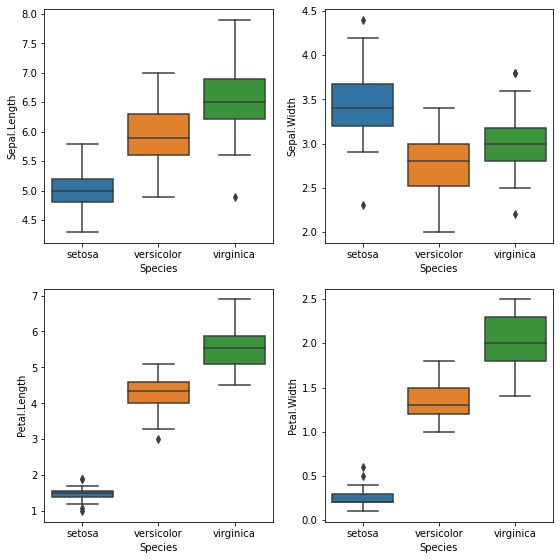

In [9]:
fig,axs = plt.subplots(2,2,figsize=(8,8))

sns.boxplot(x = 'Species', y = 'Sepal.Length', data = dataset, order = cn, ax = axs[0,0])
sns.boxplot(x = 'Species', y = 'Sepal.Width', data = dataset, order = cn, ax = axs[0,1])
sns.boxplot(x = 'Species', y = 'Petal.Length', data = dataset, order = cn, ax = axs[1,0])
sns.boxplot(x = 'Species', y = 'Petal.Width', data = dataset, order = cn, ax = axs[1,1])

fig.tight_layout(pad=1.5)

***Inference***: 
* Petal Length, and Petal width are good indicators of groups
* From the bottom two plots we can see that Setosa are the ones, that were predominantly present in the smaller values in the histograms
* Sepal width data is highly varied, consisting of outliers

### ***Violin Plots***
Shows distribution within preset classes - Setosa, Versicolor and Virginica.


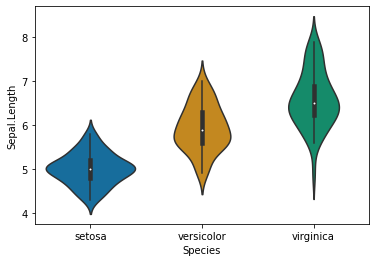

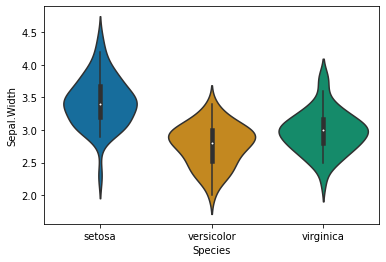

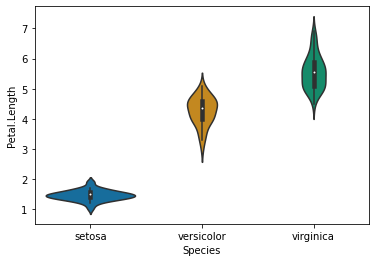

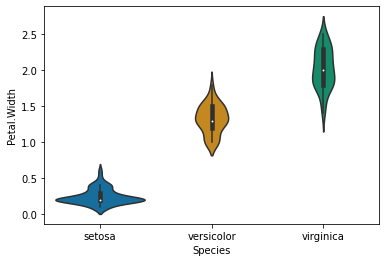

In [10]:
for feature in features:
  sns.violinplot(x="Species", y = feature, data = dataset,order=cn,palette='colorblind')
  plt.show()

***Inference***: Petal length and petal width vary the least among a class

### ***Pairs Plots***
Allows us to see both distribution of single variables and relationships between two variables

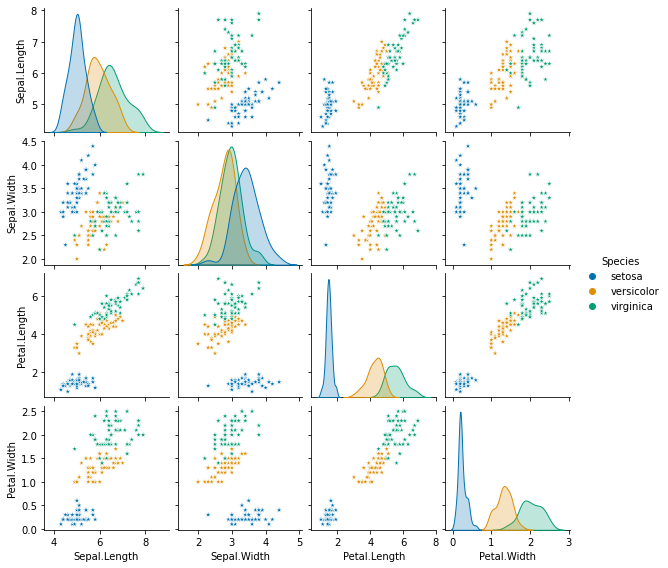

In [11]:
sns.pairplot(dataset, hue = "Species", height =2,markers="*", palette="colorblind")
plt.show()

***Inference***: 
* This reiterates that the petal measurements separate the different species better than the sepal ones
* Positive relationship between petal width and length

### ***Heat Map***
Clearly highlight the correlation values of the different features

<AxesSubplot:>

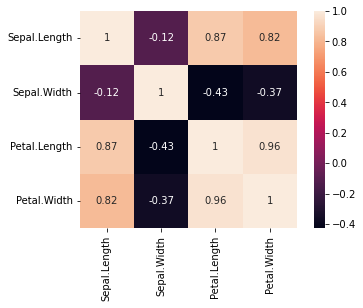

In [12]:
corrmat = dataset.corr()
sns.heatmap(corrmat,square = True, annot= True)

***Inference*** : 
* Petal measurements have highly positive correlation 
* Sepal measurements have poor correlation
* Petal measurements have high correlation with sepal length, but not with sepal width

## *Step 4*: **Splitting dataset into train & test set**
We should have a validation set as well, but due to the small size we can simplify it by using the test set to serve the purpose of validation set. 

NOTE: We implemented Stratified K-Fold Sampling to generalize it.


In [13]:
train, test = train_test_split(dataset,test_size=0.3,stratify = dataset['Species'], random_state=21)

In [14]:
#train.head(5)
print(train.shape)

(105, 5)


In [15]:
#test.head(5)
print(test.shape)

(45, 5)


In [16]:
train_X = train[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']]
train_Y = train.Species

test_X = test[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']]
test_Y = test.Species

#Stratified KFold
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

## *Step 5*: **Training different models**

### *Model 1*: Decision Tree


In [17]:
mod_dt = DecisionTreeClassifier(max_depth = 3)
mod_dt.fit(train_X,train_Y)
prediction = mod_dt.predict(test_X)
print('The accuracy of the Decision Tree is',"{:.5f}".format(metrics.accuracy_score(prediction,test_Y)))

The accuracy of the Decision Tree is 0.95556


In [18]:
mod_dt.feature_importances_

array([0.        , 0.        , 0.94632035, 0.05367965])

[Text(0.375, 0.875, 'Petal Length <= 2.45\ngini = 0.667\nsamples = 105\nvalue = [35, 35, 35]\nclass = setosa'),
 Text(0.25, 0.625, 'gini = 0.0\nsamples = 35\nvalue = [35, 0, 0]\nclass = setosa'),
 Text(0.5, 0.625, 'Petal Length <= 4.85\ngini = 0.5\nsamples = 70\nvalue = [0, 35, 35]\nclass = versicolor'),
 Text(0.25, 0.375, 'Petal Width <= 1.65\ngini = 0.108\nsamples = 35\nvalue = [0, 33, 2]\nclass = versicolor'),
 Text(0.125, 0.125, 'gini = 0.0\nsamples = 32\nvalue = [0, 32, 0]\nclass = versicolor'),
 Text(0.375, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [0, 1, 2]\nclass = virginica'),
 Text(0.75, 0.375, 'Petal Width <= 1.75\ngini = 0.108\nsamples = 35\nvalue = [0, 2, 33]\nclass = virginica'),
 Text(0.625, 0.125, 'gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]\nclass = virginica'),
 Text(0.875, 0.125, 'gini = 0.0\nsamples = 29\nvalue = [0, 0, 29]\nclass = virginica')]

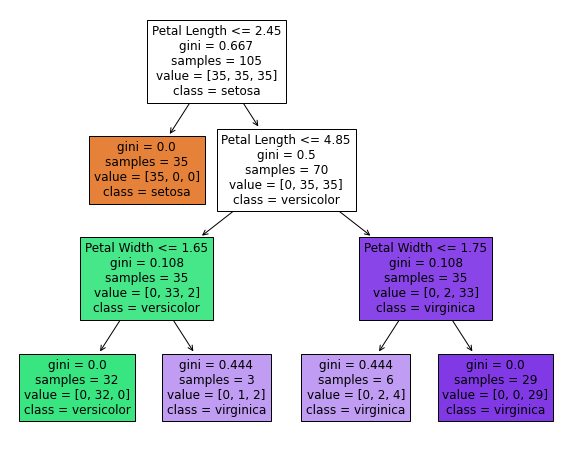

In [19]:
plt.figure(figsize=(10,8))
plot_tree(mod_dt,feature_names=ftrnames,class_names=cn,filled=True)

Text(0.5, 1.0, 'Decision Tree Confusion Matrix, without normalization')

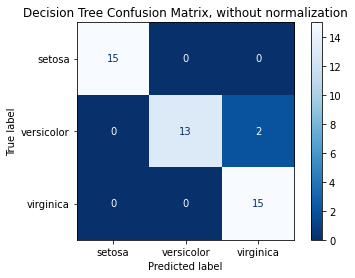

In [20]:
disp = metrics.plot_confusion_matrix(mod_dt, test_X, test_Y, display_labels=cn, cmap = plt.cm.Blues_r,normalize=None)
disp.ax_.set_title('Decision Tree Confusion Matrix, without normalization')

### *Model 2*: Random Forest Classifier


In [21]:
clf = RandomForestClassifier(n_estimators=500,max_depth=3)
clf.fit(train_X,train_Y)

predictions_clf = clf.predict(test_X)
print('The accuracy of the Random Forest Classifier is',"{:.5f}".format(metrics.accuracy_score(predictions_clf,test_Y)))

The accuracy of the Random Forest Classifier is 0.97778


In [22]:
feature_imp = pd.Series(clf.feature_importances_,index=ftrnames).sort_values(ascending=False)
feature_imp

Petal Length    0.467830
Petal Width     0.408806
Sepal Length    0.110934
Sepal Width     0.012430
dtype: float64

Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix')

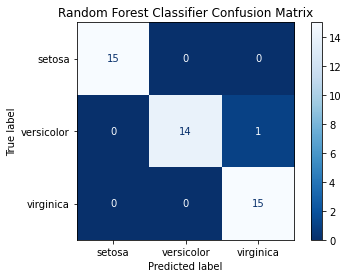

In [23]:
disp = metrics.plot_confusion_matrix(clf, test_X, test_Y, display_labels=cn, cmap = plt.cm.Blues_r)
disp.ax_.set_title('Random Forest Classifier Confusion Matrix')

### *Model 3*: Gaussian Naive Bayes

In [24]:
gaussian = GaussianNB()
gaussian.fit(train_X, train_Y)
prediction_gnb = gaussian.predict(test_X)
print('The accuracy of the Gaussian Naive Bayes Classifier is',"{:.5f}".format(metrics.accuracy_score(prediction_gnb,test_Y)))
# f1 = metrics.f1_score(test_Y,prediction_gnb,average='micro')
# print(f1)

The accuracy of the Gaussian Naive Bayes Classifier is 0.97778


Text(0.5, 1.0, 'Gaussian Naive Bayes Confusion Matrix')

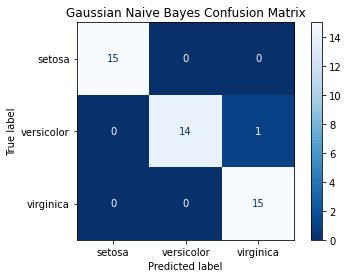

In [25]:
disp = metrics.plot_confusion_matrix(gaussian, test_X, test_Y, display_labels=cn, cmap = plt.cm.Blues_r)
disp.ax_.set_title('Gaussian Naive Bayes Confusion Matrix')

### *Model 4*: Logistic Regression

In [26]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(train_X,train_Y)
prediction_logreg = logreg.predict(test_X)
print('The accuracy of Logistic Regression is',"{:.5f}".format(metrics.accuracy_score(prediction_logreg,test_Y)))

The accuracy of Logistic Regression is 0.97778


Text(0.5, 1.0, 'Logistic Regression (One v/s all) Confusion Matrix')

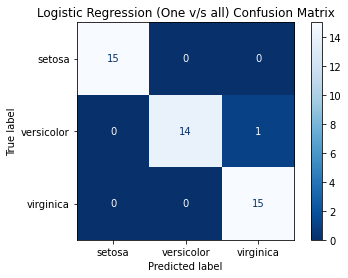

In [27]:
disp = metrics.plot_confusion_matrix(logreg, test_X,test_Y,display_labels=cn,cmap = plt.cm.Blues_r)
disp.ax_.set_title("Logistic Regression (One v/s all) Confusion Matrix")

### *Model 5*: K Nearest Neighbours

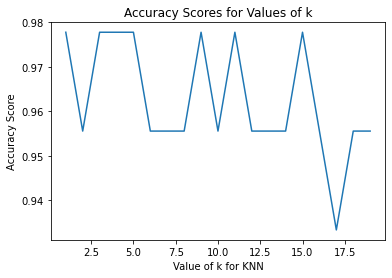

In [28]:
k_range = list(range(1,20))
scores=[]
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_X,train_Y)
  pred_Y = knn.predict(test_X)
  scores.append(metrics.accuracy_score(test_Y,pred_Y))

plt.plot(k_range,scores)
plt.ylabel('Accuracy Score')
plt.xlabel('Value of k for KNN')
plt.title('Accuracy Scores for Values of k')
plt.show()

In [29]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_X,train_Y)
prediction_knn = knn.predict(test_X)
print('The accuracy of the K Nearest Neighbours algorithm is',"{:.5f}".format(metrics.accuracy_score(prediction_knn,test_Y)))

The accuracy of the K Nearest Neighbours algorithm is 0.97778


Text(0.5, 1.0, 'K Nearest Neighbours Confusion Matrix')

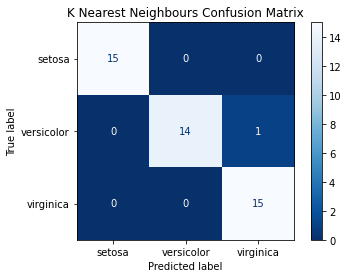

In [30]:
disp = metrics.plot_confusion_matrix(knn, test_X, test_Y, display_labels=cn, cmap = plt.cm.Blues_r)
disp.ax_.set_title('K Nearest Neighbours Confusion Matrix')

Hyperparameter Tuning using BayesSearchCV


In [31]:
params=dict()
params['n_neighbors']=(1,81,'log-uniform')

search = BayesSearchCV(estimator = KNeighborsClassifier(),search_spaces=params,cv=skf)
search.fit(dataset_X,dataset_Y)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
              estimator=KNeighborsClassifier(),
              search_spaces={'n_neighbors': (1, 81, 'log-uniform')})

In [32]:
# print(f"{search.best_score_:.4f}")
print(search.best_params_)

OrderedDict([('n_neighbors', 17)])


### *Model 6* : Linear SVC

In [33]:
linear_svc = SVC(kernel='linear',max_iter=10000)
linear_svc.fit(train_X,train_Y)
prediction_svc = linear_svc.predict(test_X)
print('The accuracy of the Linear SVC is',"{:.5f}".format(metrics.accuracy_score(prediction_svc,test_Y)))

The accuracy of the Linear SVC is 0.97778


Text(0.5, 1.0, 'Linear SVC Confusion Matrix')

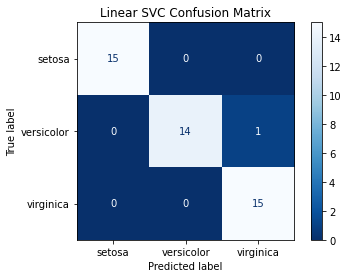

In [34]:
disp = metrics.plot_confusion_matrix(knn,test_X,test_Y,display_labels=cn, cmap = plt.cm.Blues_r)
disp.ax_.set_title("Linear SVC Confusion Matrix")

Hyperparameter Tuning using BayesSearchCV

In [35]:
params=dict()
params['C']=(1,100,'log-uniform')
search = BayesSearchCV(estimator = SVC(kernel='linear'),search_spaces=params,cv=skf)
search.fit(dataset_X,dataset_Y)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
              estimator=SVC(kernel='linear'),
              search_spaces={'C': (1, 100, 'log-uniform')})

In [36]:
# print(f"{search.best_score_:.4f}")
print(search.best_params_)

OrderedDict([('C', 1)])


**Accuracy** as the metric:
(Using **70-30** train-test split)

1. Decision Tree : 0.95556
2. Random Forest Classifier : 0.97778
3. Gaussian Naive Bayes : 0.97778
4. Logistic Regression : 0.97778
5. K Nearest Neighbours : 0.97778
6. Linear SVC : 0.97778

## *Step 6*: **Further Selection**

We thought of using Cross Validation Score as another metric to decide which model is optimum.

In [37]:
models=[]
models.append(('Decision Tree',DecisionTreeClassifier(max_depth=3)))
models.append(('Random Forest Classifier',RandomForestClassifier(n_estimators=150, max_depth=3)))
models.append(('Gaussian Naive Bayes',GaussianNB()))
models.append(('Logistic Regression',LogisticRegression(solver='lbfgs',max_iter=10000)))
models.append(('K-Nearest Neighbours',KNeighborsClassifier(n_neighbors=10)))
models.append(('Linear SVC',SVC(kernel='linear',max_iter=10000)))

In [38]:
results=[]
for name,model in models:
  skf = StratifiedKFold(n_splits=10, shuffle = True,random_state=1)
  score = cross_val_score(model,dataset_X,dataset_Y,cv=skf,n_jobs=1)
  results.append((name,score))


In [39]:
for name,result in results:
  print(f"{name}: {result.mean():.4f}")

Decision Tree: 0.9467
Random Forest Classifier: 0.9533
Gaussian Naive Bayes: 0.9600
Logistic Regression: 0.9600
K-Nearest Neighbours: 0.9733
Linear SVC: 0.9867


##**Conclusion**
Linear SVC performs the best, based on both cross_val_score and accuracy